# Bias-Variance Trade-Off in Decision Trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import random
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

The following cell defines and plots the data for this regression problem. The true regression function is `f`; the response `y` is `f` plus noise. The true function is -1 above the line `x1==x2` and 1 below the line.

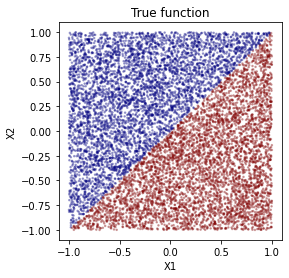

In [3]:
n = 10000 # Amount of points to show
np.random.seed(1412)

X = np.random.uniform(low=-1, high=1, size=2*n).reshape(n,2)
# True function
f = np.sign(X[:,0] - X[:,1])
# Response
y = f + np.random.normal(0, 1, size=n)

fig = plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], c=f, alpha=.3, s=2.5, cmap='jet')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('True function')
plt.show()

### Building regression trees with different depth

Let's build a sequence of regression trees using this data, where we predict `y` from `x1` and `x2`, varying the maximum tree depth from 1 to 7. We'll use the following strategy:

* Train each tree on a random set of 5% of all data points
* Test on the remaining data points
* Run 500 trials (train/test splits) for each depth.
* Plot the MSE as a function of the maximum tree depth

100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.01it/s]


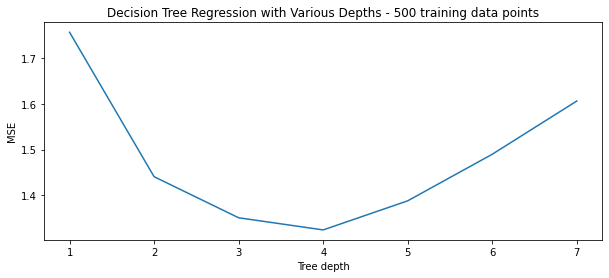

In [4]:
trials = 500
test_size = 0.95
tree_depths = np.arange(1, 8)
test_MSE = np.zeros(len(tree_depths))

from tqdm import tqdm

for d in tqdm(tree_depths):
    #Build DT model
    rtree = DecisionTreeRegressor(max_depth=d)
    MSE_trials = np.zeros(trials)
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size)
        # Train DT model
        model_r = rtree.fit(X_train, y_train)
        # Test DT model
        y_pred = model_r.predict(X_test)
        # Calculate the MSE and add to sum_MSE
        MSE_trials[trial] = np.mean(np.square(y_test-y_pred))
    test_MSE[d-1] = np.mean(MSE_trials)
        

fig = plt.figure(figsize=(10,4))
plt.plot(tree_depths, test_MSE)
plt.xlabel('Tree depth')
plt.ylabel('MSE')
plt.title('Decision Tree Regression with Various Depths - ' + 
          f'{int((1-test_size)*n)} training data points')

plt.show()

The point where the MSE-curve (in function of the tree depth) reaches its minimum is at a tree depth equal to 4. As a consequence, one should opt for a tree depth of 4, as the goal is to minimize the mean squared error.

### Size of tree and amount of training data

If the regression trees were trained on 50% of the data points, rather than 5%, how would the choice of tree depth change? Let's see what happens:

100%|█████████████████████████████████████████████| 7/7 [00:12<00:00,  1.76s/it]


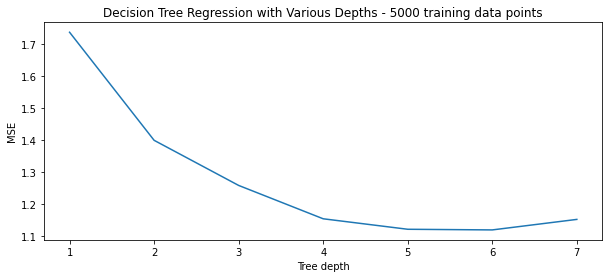

In [5]:
trials = 500
test_size = 0.50
tree_depths = np.arange(1, 8)
test_MSE = np.zeros(len(tree_depths))

for d in tqdm(tree_depths):
    #Build DT model
    rtree = DecisionTreeRegressor(max_depth=d)
    MSE_trials = np.zeros(trials)
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size)
        # Train DT model
        model_r = rtree.fit(X_train, y_train)
        # Test DT model
        y_pred = model_r.predict(X_test)
        # Calculate the MSE and add to sum_MSE
        MSE_trials[trial] = np.mean(np.square(y_test-y_pred))
    test_MSE[d-1] = np.mean(MSE_trials)
        

fig = plt.figure(figsize=(10,4))
plt.plot(tree_depths, test_MSE)
plt.xlabel('Tree depth')
plt.ylabel('MSE')
plt.title('Decision Tree Regression with Various Depths - ' + 
          f'{int((1-test_size)*n)} training data points')

plt.show()

If more training samples are used, the model will be less likely to overfit, because having more training data points is more representative for your problem. This allows the model to have a greater depth, because there is less danger of overfitting. Also, if less training data points are used, this leads to more variance in the result (as the training samples differ significantly). Using more data points will lead to smaller variance, because the training sets look more alike. The new optimal tree depth is equal to 6.

### Estimate the squared bias and variance

We will now estimate the squared bias and variance of the trees as a function of the maximum depth. This is possible here because we know the true function `f`, which was defined above. We will again use 5% of our data for training.

To estimate the squared bias and variance, we can evaluate each of the models on each of the $n=10,000$ data points. We can then estimate the squared bias and variance of the predictions $\hat y_i = \hat f(x_i)$ and take the average 
over all the data points.

100%|█████████████████████████████████████████████| 7/7 [00:04<00:00,  1.58it/s]


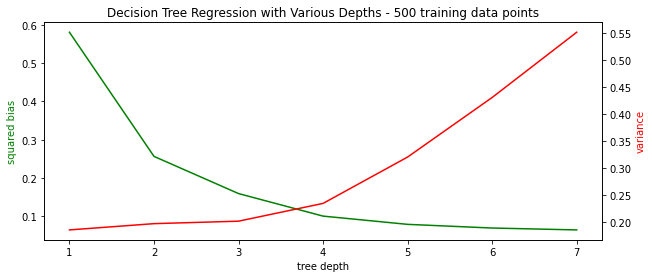

In [6]:
trials = 500
tree_depth = np.arange(1, 8)
test_size = 0.95
bias_squared = []
variance = []

for d in tqdm(tree_depths):
    rtree = DecisionTreeRegressor(max_depth=d)
    E_yhat = np.zeros(n)
    E_yhat_squared = np.zeros(n)
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size)
        # Train DT model
        model_r = rtree.fit(X_train, y_train)
        # Test DT model
        E_yhat += model_r.predict(X)
        E_yhat_squared += model_r.predict(X)**2
    E_yhat /= trials
    E_yhat_squared /= trials
    bias_squared.append(np.mean((E_yhat - f)**2))
    variance.append(np.mean(E_yhat_squared - E_yhat**2))
    

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()
ax1.plot(tree_depths, bias_squared, 'g-')
ax2.plot(tree_depths, variance, 'r-')
ax1.set_xlabel('tree depth')
ax1.set_ylabel('squared bias', color='g')
ax2.set_ylabel('variance', color='r')
plt.title('Decision Tree Regression with Various Depths - ' + 
          f'{int((1-test_size)*n)} training data points')
plt.show()

The resulting plot of the squared bias and variance makes sense. Shallow trees (low tree depth) have a high bias and a low variance. As there are only a small number of terminal leaves and the model is less complex, the predicted values will generally be further away from the real value (hence higher bias squared), but the predicted values will lie close to each other (low variance). Deep trees have a low bias and a high variance. As there are a high number of terminal leaves and the model is more complex, the predicted values will generally be closer to the real value (hence lower bias squared), but the predicted values will lie further from each other (higher variance). This behavior is clearly visible in the plot.

The plot of the squared bias and variance is consistent with the plot of the previously computed MSE. The point were the sum of the squared bias and variance reachest its lowest value is at a tree depth of 4, which corresponds to the minimum MSE value from the plot in the first subsection.

### Changing the target function

Now, suppose that the true function is changed from a step function on the diagonal to a step function that is along the vertical line `X1=0`.

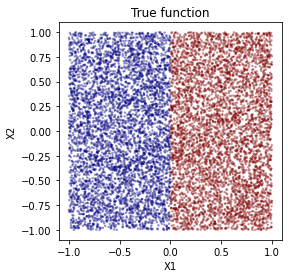

In [7]:
n = 10000 # Amount of points to show
np.random.seed(1412)

X = np.random.uniform(low=-1, high=1, size=2*n).reshape(n,2)
f = np.sign(X[:,0])
y = f + np.random.normal(size=n)

fig = plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], c=f, alpha=.3, s=2.5, cmap='jet')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('True function')
plt.show()

100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.08it/s]


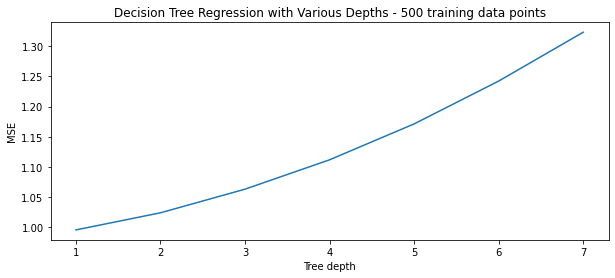

In [8]:
trials = 500
test_size = 0.95
tree_depths = np.arange(1, 8)
test_MSE = np.zeros(len(tree_depths))

from tqdm import tqdm

for d in tqdm(tree_depths):
    #Build DT model
    rtree = DecisionTreeRegressor(max_depth=d)
    MSE_trials = np.zeros(trials)
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size)
        # Train DT model
        model_r = rtree.fit(X_train, y_train)
        # Test DT model
        y_pred = model_r.predict(X_test)
        # Calculate the MSE and add to sum_MSE
        MSE_trials[trial] = np.mean(np.square(y_test-y_pred))
    test_MSE[d-1] = np.mean(MSE_trials)
        

fig = plt.figure(figsize=(10,4))
plt.plot(tree_depths, test_MSE)
plt.xlabel('Tree depth')
plt.ylabel('MSE')
plt.title('Decision Tree Regression with Various Depths - ' + 
          f'{int((1-test_size)*n)} training data points')

plt.show()

100%|█████████████████████████████████████████████| 7/7 [00:04<00:00,  1.65it/s]


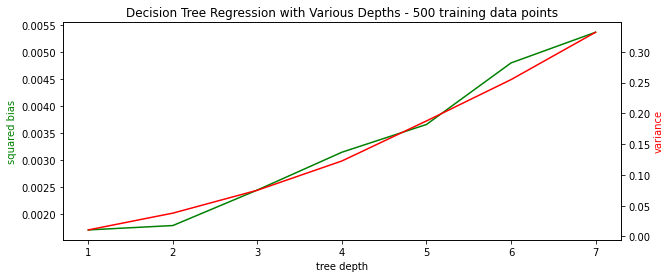

In [9]:
trials = 500
tree_depth = np.arange(1, 8)
test_size = 0.95
bias_squared = []
variance = []

for d in tqdm(tree_depths):
    rtree = DecisionTreeRegressor(max_depth=d)
    E_yhat = np.zeros(n)
    E_yhat_squared = np.zeros(n)
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size)
        # Train DT model
        model_r = rtree.fit(X_train, y_train)
        # Test DT model
        E_yhat += model_r.predict(X)
        E_yhat_squared += model_r.predict(X)**2
    E_yhat /= trials
    E_yhat_squared /= trials
    bias_squared.append(np.mean((E_yhat - f)**2))
    variance.append(np.mean(E_yhat_squared - E_yhat**2))
    

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()
ax1.plot(tree_depths, bias_squared, 'g-')
ax2.plot(tree_depths, variance, 'r-')
ax1.set_xlabel('tree depth')
ax1.set_ylabel('squared bias', color='g')
ax2.set_ylabel('variance', color='r')
plt.title('Decision Tree Regression with Various Depths - ' + 
          f'{int((1-test_size)*n)} training data points')
plt.show()

Generally, one would expect a high bias for shallow trees, and a low bias for deep trees. This is not the case here, because a small tree is the optimal choice, it leads to the lowest squared bias. Increasing the tree will only increase the squared bias. The plots are consistent with the plot of the MSE, because they are all increasing.